/home/sid/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)


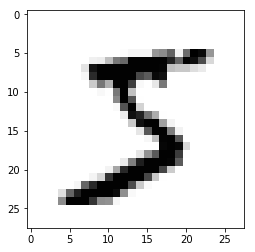

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np
from tqdm import trange

In [14]:
def transformed(x, y):
    x_trans = np.reshape(x,[x.shape[0], -1])
    y_trans = (np.arange(num_labels) == y[:,None]).astype(np.float32)
    return x_trans, y_trans

In [15]:
def iterate_minibatches(inputs, targets, batchsize):
    indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [16]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [17]:
# Initialize shape vars
tf.reset_default_graph()
num_features = X_train.shape[1]*X_train.shape[2]
num_neurons_layer_1 = 256
num_labels = 10

In [18]:
# Reformat data (flattened)
X_train_reformated, y_train_reformated = transformed(X_train, y_train)
X_val_reformated, y_val_reformated = transformed(X_val, y_val)
X_test_reformated, y_test_reformated = transformed(X_test, y_test)

In [19]:
# Model parameters - weights and bias
W1 = tf.get_variable("Weights1", [num_features, num_neurons_layer_1], 
                     initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("biases1", [num_neurons_layer_1], initializer = tf.zeros_initializer())

W2 = tf.get_variable("Weights2", [num_neurons_layer_1, num_labels], 
                     initializer = tf.contrib.layers.xavier_initializer(seed = 1),
                     regularizer = tf.contrib.layers.l2_regularizer(scale=0.25))
b2 = tf.get_variable("biases2", [num_labels], initializer = tf.zeros_initializer())

In [20]:
# Placeholders for the input data
input_X = tf.placeholder(tf.float32, shape=[None, num_features])
input_y = tf.placeholder(tf.float32, shape=[None, num_labels])

In [21]:
# The model code
hidden_layer_1 = tf.nn.relu(tf.matmul(input_X, W1) + b1)

prediction_y = tf.nn.softmax(tf.matmul(hidden_layer_1, W2) + b2)

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=prediction_y, labels=input_y))

optimizer = tf.train.AdamOptimizer(0.001, 0.70, 0.90).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [ ]:
%%time
with tf.Session() as s:
    test_cost = []
    val_cost = []
    s.run(tf.global_variables_initializer())
    for epoch in range(26):
        for x_batch, y_batch in iterate_minibatches(X_train_reformated,y_train_reformated,batchsize=130):
            s.run(optimizer, {input_X: x_batch, input_y: y_batch})

        test_cost.append(s.run(loss, {input_X: X_test_reformated, input_y: y_test_reformated}))
        val_cost.append(s.run(loss, {input_X: X_val_reformated, input_y: y_val_reformated}))

        if epoch % 5 == 0:
            train_acc = accuracy(s.run(prediction_y, {input_X: X_train_reformated}), y_train_reformated)
            val_acc = accuracy(s.run(prediction_y, {input_X: X_val_reformated}), y_val_reformated)
            print(f'Epoch: {epoch} - Train accuracy: {train_acc}, Val accuracy: {val_acc}')

    plt.plot(test_cost, label='test')
    plt.plot(val_cost, label='val')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
    print("Test accuracy: ", 
          accuracy(s.run(prediction_y, {input_X: X_test_reformated}), y_test_reformated))

  4%|▍         | 16/384 [00:00<00:02, 151.09it/s]

Epoch: 0 - Train accuracy: 93.466, Val accuracy: 93.72


  4%|▍         | 16/384 [00:00<00:02, 152.35it/s]

Epoch: 5 - Train accuracy: 97.668, Val accuracy: 97.0


  3%|▎         | 10/384 [00:00<00:03, 96.32it/s]

Epoch: 10 - Train accuracy: 98.742, Val accuracy: 97.51


  4%|▍         | 15/384 [00:00<00:02, 149.80it/s]

Epoch: 15 - Train accuracy: 99.076, Val accuracy: 97.62


  4%|▍         | 15/384 [00:00<00:02, 149.55it/s]

Epoch: 20 - Train accuracy: 99.414, Val accuracy: 97.78


 81%|████████  | 311/384 [00:02<00:00, 141.43it/s]